# TP 4 : Fillrates

BROSSETTE Camille  
LEGRAND Maxime

## 0. Set-up

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from datetime import datetime

In [2]:
num = [720, 1102, 1662, 1664, 2255, 2574, 2586, 5685, 8695864]
dft = {}
for i in range(1, 10):
    dft[i] = pd.read_pickle("../data4/strades_info_"+str(num[i-1])+".h5")

In [3]:
for i in range(1,10):
    dti = dft[i]['ts_market'].iloc[0]
    dft[i] = dft[i][(dft[i]['bid'] < dft[i]['ask'])
                    &(dft[i]['bid'] != 0)
                    &(dft[i]['bid'] != 999999)
                    &(dft[i]['ask'] != 0)
                    &(dft[i]['ask'] != 999999)
                    &(dft[i]['source'] == 'LSE')
                    &(dft[i]['volume'] != 0)
                    &(dft[i]['qty'] != 0)
                    &(dft[i]['side'] != 'U')]
    if i==2:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 7, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 15, 30))]
    else:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 8, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 16, 30))]

In [4]:
tick = [0.05, 0.05, 0.1, 0.01, 0.05, 0.1, 0.1, 0.1, 0.05]

In [5]:
for i in range(1,10):
    dft[i]['bid1']=dft[i]['bid']-tick[i-1]
    dft[i]['bid2']=dft[i]['bid']-2*tick[i-1]
    dft[i]['ask1']=dft[i]['ask']+tick[i-1]
    dft[i]['ask2']=dft[i]['ask']+2*tick[i-1]

In [6]:
trades = {}
for i in range(1,10):
    trades[i] = dft[i].set_index('ts_market')

## I. Passive Orders and Probability of Execution

### 1. Functions

In [7]:
def Bid_proba_ex(Trades, time_step):
    
    Bid_dist = ['bid', 'bid1', 'bid2']
    
    Bid = np.array([Trades[Bid_dist[0]].resample(time_step).first(),
                    Trades[Bid_dist[1]].resample(time_step).first(),
                    Trades[Bid_dist[2]].resample(time_step).first()])
                    
    Trade = Trades['price'].resample(time_step).min()
    
    res = np.array([[(Trade[i]<Bid[0][i]) for i in range(len(Bid[0]))],
                   [(Trade[i]<Bid[1][i]) for i in range(len(Bid[1]))],
                   [(Trade[i]<Bid[2][i]) for i in range(len(Bid[2]))]])
    
    resf = np.array([res[0].mean(),
                     res[1].mean(),
                     res[2].mean()])
    
    return resf    

In [8]:
def Ask_proba_ex(Trades, time_step):
    Ask_dist = ['ask', 'ask1', 'ask2']
    
    Ask = np.array([Trades[Ask_dist[0]].resample(time_step).first(),
                    Trades[Ask_dist[1]].resample(time_step).first(),
                    Trades[Ask_dist[2]].resample(time_step).first()])
                    
    Trade = Trades['price'].resample(time_step).max()
    
    res = np.array([[(Trade[i]>Ask[0][i]) for i in range(len(Ask[0]))],
                   [(Trade[i]>Ask[1][i]) for i in range(len(Ask[1]))],
                   [(Trade[i]>Ask[2][i]) for i in range(len(Ask[2]))]])
    resf = np.array([res[0].mean(),
                     res[1].mean(),
                     res[2].mean()])
    
    return resf

### 2. Curves

In [9]:
J = 5 # Dataset used from now
t0 = 30 # Minimum time
T = 150 # Maximum time
dt = 30 # Time step in range

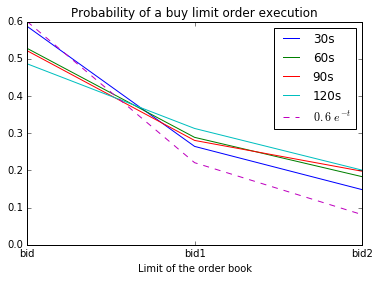

In [10]:
f, ax = plt.subplots()

for s in range(t0,T,dt):
    P_Bid = Bid_proba_ex(trades[J], (str(s) + 's'))
    ax.plot([0,1,2], P_Bid/P_Bid.sum(), label = (str(s) + 's'))
    
ax.plot([0,1,2], [0.6*np.exp(0), 0.6*np.exp(-1), 0.6*np.exp(-2)], '--', label = '$0.6\ e^{-t}$')
    
ax.set_title('Probability of a buy limit order execution')
ax.set_xlabel('Limit of the order book')
ax.set_xticks([0,1,2])
ax.set_xticklabels(('bid', 'bid1', 'bid2'))
ax.legend()

plt.show()

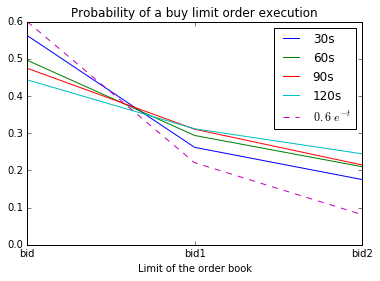

In [11]:
f, ax = plt.subplots()

for s in range(t0,T,dt):
    P_Ask = Ask_proba_ex(trades[J], (str(s) + 's'))
    ax.plot([0,1,2], P_Ask/P_Ask.sum(), label = (str(s) + 's'))
    
ax.plot([0,1,2], [0.6*np.exp(0), 0.6*np.exp(-1), 0.6*np.exp(-2)], '--', label = '$0.6\ e^{-t}$')
    
ax.set_title('Probability of a buy limit order execution')
ax.set_xlabel('Limit of the order book')
ax.set_xticks([0,1,2])
ax.set_xticklabels(('bid', 'bid1', 'bid2'))
ax.legend()

plt.show()

On remarque que lorsque le pas de temps tend vers $0$, les probabilités semblent converger vers une fonction exponentielle. Les graphes ci-dessus les mettent en correspondance avec $t \mapsto 0.6\ e^{-t}$. On observe une symétrie des paramètres de l'exponentielle entre le `bid` et l'`ask`.

## II. Fillrate

### 1. Function

In [12]:
def Fillrate(Trades, dist, time_step, time_waiting):
    Bid_dist = ['bid', 'bid1', 'bid2']
    Bid = Trades[Bid_dist[dist]].resample(time_step).first()
    Trade = Trades['price'].resample(time_step).min()
    
    Res = Trade
    for i in range(len(Bid)):
        Res[i] = (Trade[i]<Bid[i])
    
    res = Res.resample(time_waiting).sum()    
    
    return res

Comme dans l'énoncé, on fait les test avec une quantité $q=1$, plus simple à implanter et bien assez représentatif de la donnée que l'on cherche à représenter.

### 2. Plotting functions

In [13]:
def floor(x):
    if np.isnan(x):
        return 0
    else:
        return int(np.floor(x))

In [14]:
def disp(x):
    if (x==0):
        return '00'
    else:
        return str(x)

In [15]:
def plotFillRate(d=0, dt='10s', DT='5Min', Hm=8, HM=16.5, J=J, Width=16): 
    # The alignment works bad for J=2
    
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp_trades = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
    frate = Fillrate(temp_trades, d, dt, DT)
    price = temp_trades['price'].resample(DT).mean()
        
    # Plot
    color = ['lightgreen', 'orange', 'cyan']
    
    f, ax = plt.subplots(2, figsize=(Width,4), sharex=True)
    ax[0].step(np.linspace(Hm,HM,len(price)), price, color='blue',
               label='Price from '+disp(hm)+':'+disp(mm)+' to '+disp(hM)+':'+disp(mM))
    ax[0].legend()
    ax[0].set_title('Fillrate for $d='+str(d)+'$, $dt=$'+dt+' and $\Delta T=$'+str(DT))
    ax[1].bar(np.linspace(Hm,HM,len(frate)), frate, label='Fillrate for $d='+str(d)+'$', width=0.05, color=color[d])
    ax[1].legend()
    
    plt.show()

### 3. Curves

On donne ci-dessous des exemples d'utilisation de la fonction `plotFillRate`, que le lecteur est invité à expérimenter. On peut changer l'ensemble de données avec le paramètre `J` et la largeur du tracé avec `Width` (initialement à `16`, n'hésitez pas à l'agrandir si vous disposez d'un écran d'une taille suffisante).

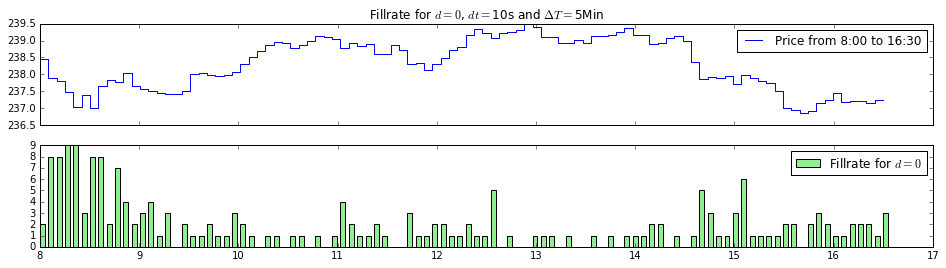

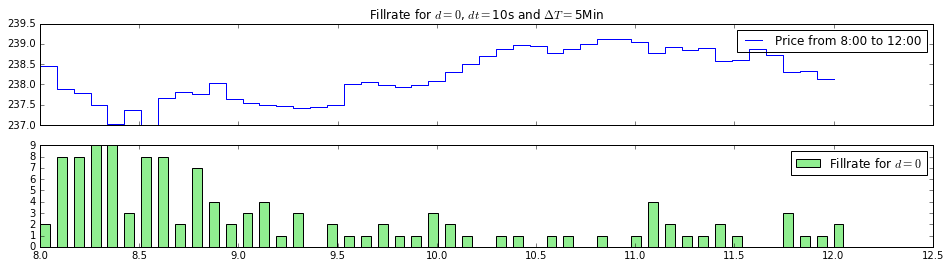

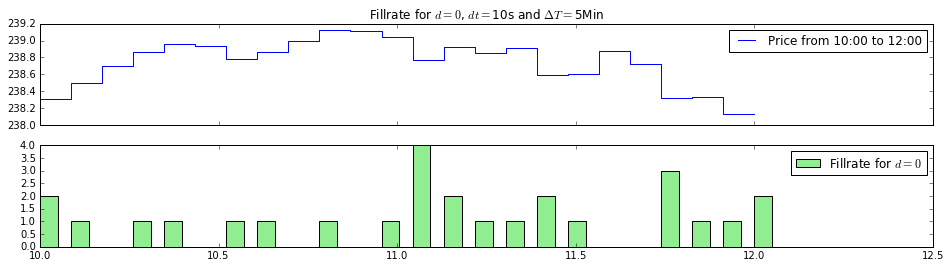

In [16]:
# Exemple 1 : Tracés pour différentes plages horaires

plotFillRate(Hm=8, HM=16.5)
plotFillRate(Hm=8, HM=12)
plotFillRate(Hm=10, HM=12)

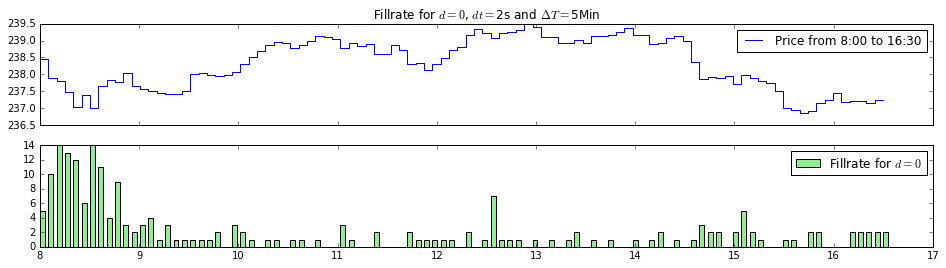

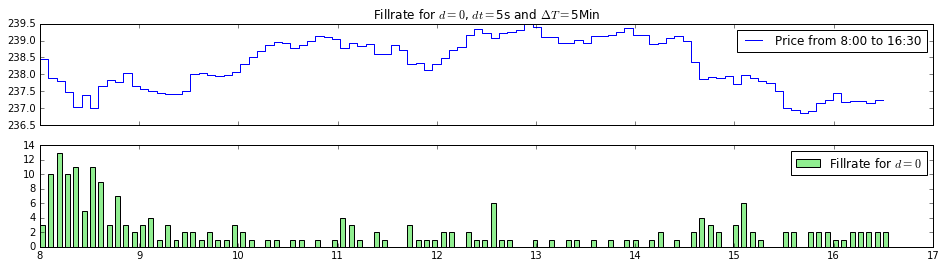

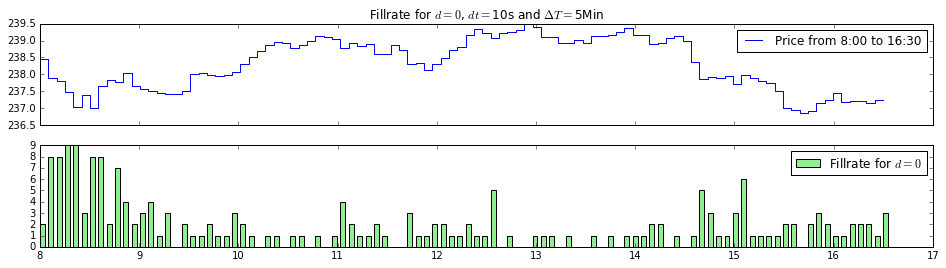

In [17]:
# Exemple 2 : Tracé pour différentes échelles de temps

plotFillRate(dt='2s', DT='5Min')
plotFillRate(dt='5s', DT='5Min')
plotFillRate(dt='10s', DT='5Min')

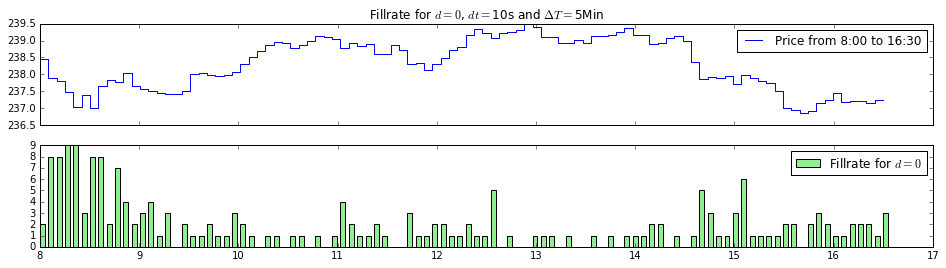

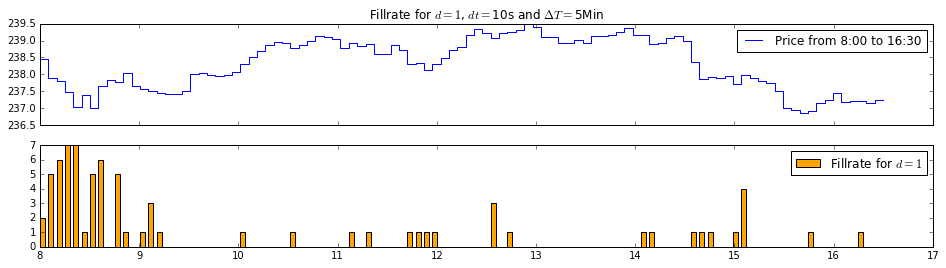

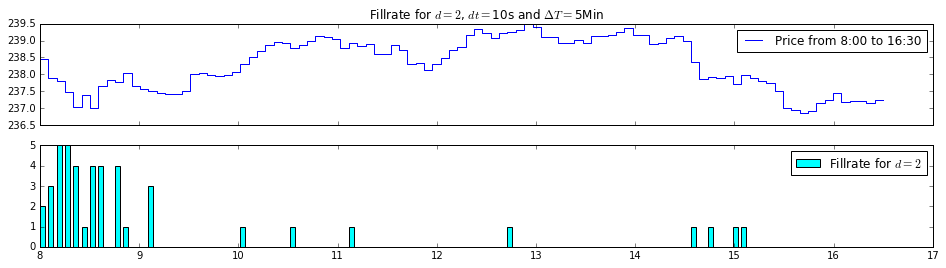

In [18]:
# Exemple 3 : Tracés pour différentes distances

for d in range(0,3): plotFillRate(d=d)

## III. Inventory and Market Making

### 1. Inventory

#### Regular plots

In [19]:
def plotInventory(d_l=[0,1,2], dt='10s', DT_l=['10Min','5Min','2Min'], Hm=8, HM=16.5, J=J,
                  rows = 1, cols = 1, Width=16, Height=8): 
    # The alignment works bad for J=2
    
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp_trades = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
        
    # Plot
    f, ax = plt.subplots(rows, cols, figsize=(Width,Height))
    ax.set_title('Inventory for $d\in'+str(d_l)+'$, $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
    for d in d_l:
        for DT in DT_l:
            inv = Fillrate(temp_trades, d, dt, DT).cumsum()
            ax.step(np.linspace(Hm,HM,len(inv)), inv, label='$d='+str(d)+',\ \Delta T=$'+DT)
    ax.legend(loc=2)
    
    plt.show()

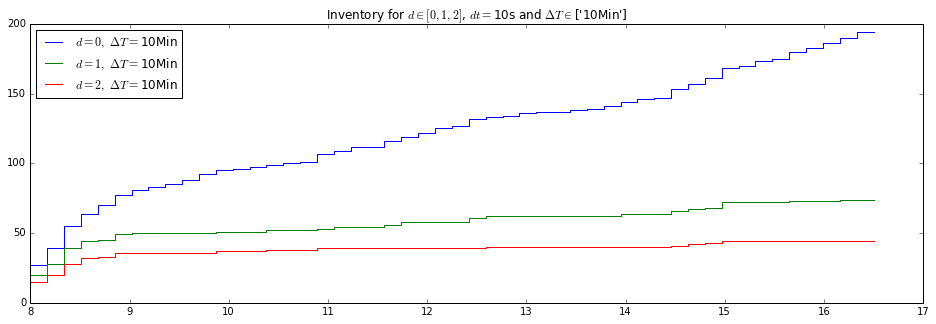

In [20]:
plotInventory(DT_l=['10Min'], Height=5)

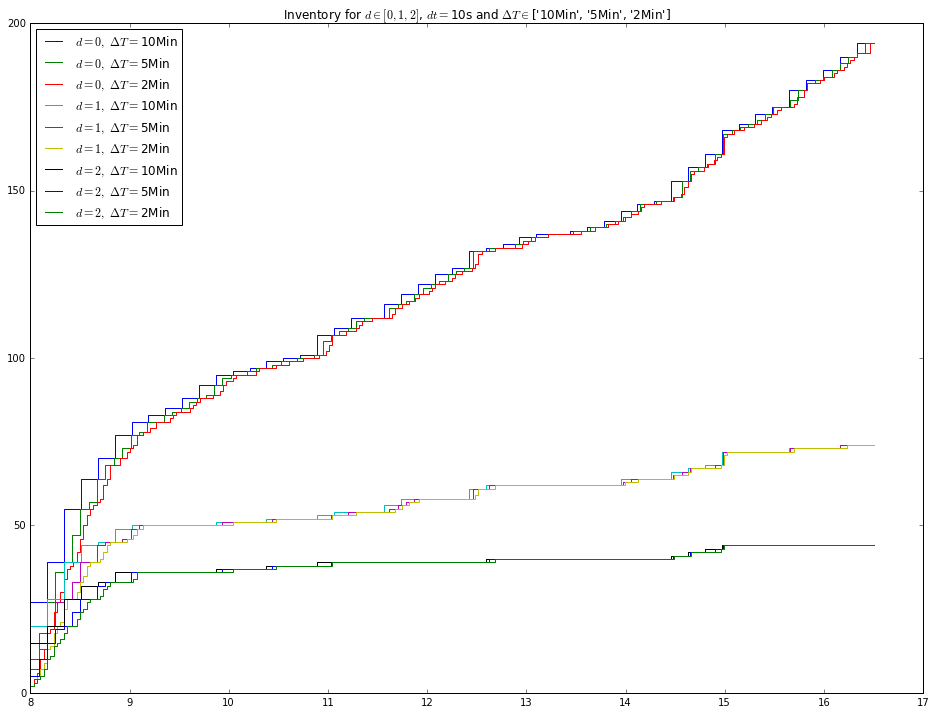

In [21]:
plotInventory(Height=12)

#### Comparison with Volatility $\sigma$ and Spread $S$

In [22]:
def plotComparedInventory(d_l=[0], dt='10s', DT_l=['2Min'], Hm=8, HM=16.5, J=J,
                  rows = 1, cols = 1, Width=16, Height=8, vol=True, spread=True): 
    # The alignment works bad for J=2
    
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
        
    # Plot
    if vol:
        f1, ax1 = plt.subplots(rows, cols, figsize=(Width,Height))
        ax1.set_title('$V_t,/ \sigma_t$ for $d\in'+str(d_l)+'$, $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
        for DT in DT_l:
            vol = (((temp['price']-temp['price'].shift()).apply(lambda x: x**2)).resample(DT).sum()).apply(np.sqrt)
            for d in d_l:
                V = Fillrate(temp, d, dt, DT).cumsum()
                ax1.step(np.linspace(Hm,HM,len(V)), V, label='$V_t$ pour $d='+str(d)+',\ \Delta T=$'+DT)
                ax1.step(np.linspace(Hm,HM,len(vol)), vol*V[len(V)-1]/vol.max(), 
                         label='$\sigma_t$ pour $\Delta T=$'+DT)
        ax1.legend()
    
    if spread:
        f2, ax2 = plt.subplots(rows, cols, figsize=(Width,Height))
        ax2.set_title('$V_t,\ S_t$ for $d\in'+str(d_l)+'$, $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
        for DT in DT_l:
            spread = (temp['ask'] - temp['bid']).resample(DT).mean()
            for d in d_l:
                V = Fillrate(temp, d, dt, DT).cumsum()
                ax2.step(np.linspace(Hm,HM,len(V)), V, label='$V_t$ pour $d='+str(d)+',\ \Delta T=$'+DT)
                ax2.step(np.linspace(Hm,HM,len(spread)), spread*V[len(V)-1]/spread.max(),
                         label='$S_t$ pour $\Delta T=$'+DT)
        ax2.legend()
    
    plt.show()

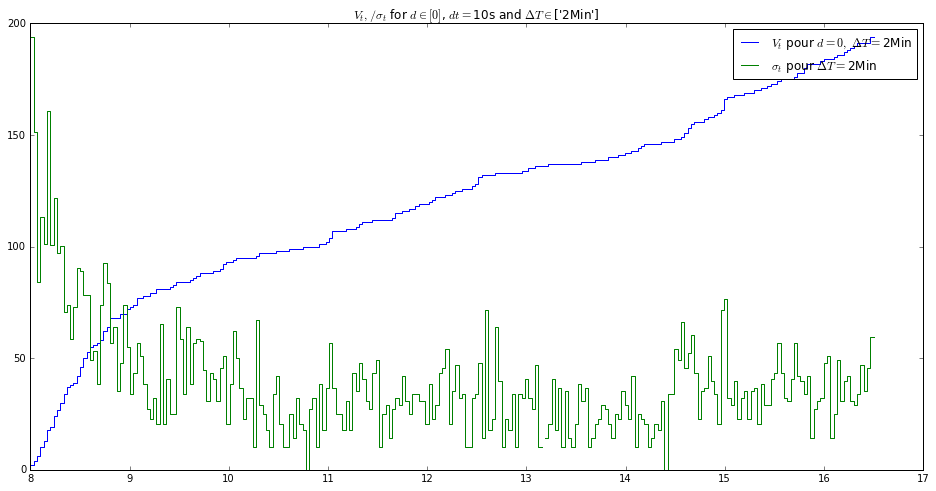

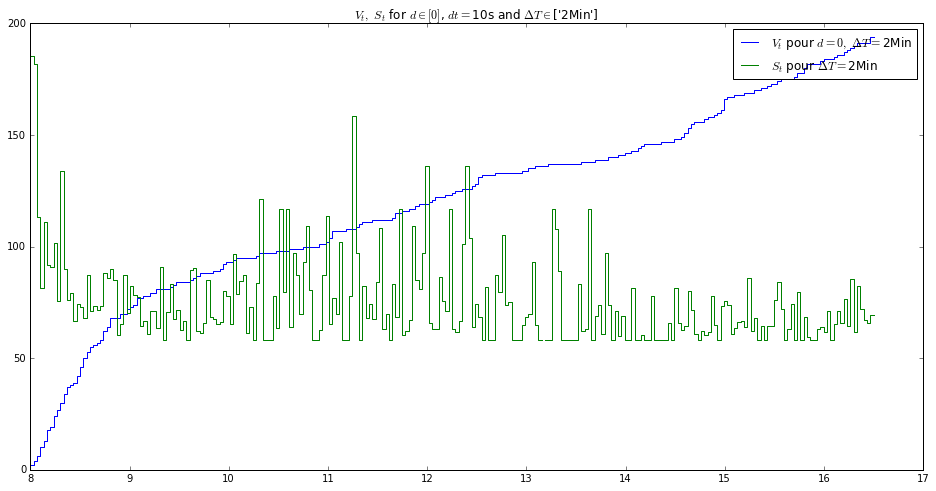

In [23]:
plotComparedInventory()

### 2. Static Market Making

In [24]:
def completeFillrate(Trades, d, dt, DT):
    Bid_dist = ['bid', 'bid1', 'bid2']
    Ask_dist = ['ask', 'ask1', 'ask2']
    Bid = Trades[Bid_dist[d]].resample(dt).first()
    Ask = Trades[Ask_dist[d]].resample(dt).first()
    
    resBid = Trades['price'].resample(dt).min()
    for i in range(len(Bid)):
        resBid[i] = (resBid[i]<Bid[i])
    
    resAsk = Trades['price'].resample(dt).max()
    for i in range(len(Ask)):
        resAsk[i] = (resAsk[i]>Ask[i])
    
    res = {}
    res['Bid'] = resBid.resample(DT).sum()    
    res['Ask'] = resAsk.resample(DT).sum()  
    
    return res

In [25]:
def plotCompleteInventory(d_l=[0,1,2], dt='10s', DT_l=['2Min'], Hm=8, HM=16.5, J=J,
                  rows = 1, cols = 1, Width=16, Height=8): 
    # The alignment works bad for J=2
    
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp_trades = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
        
    # Plot
    f, ax = plt.subplots(rows, cols, figsize=(Width,Height))
    ax.set_title('Complete inventory for $d\in'+str(d_l)+'$, $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
    for d in d_l:
        for DT in DT_l:
            invBid = completeFillrate(temp_trades, d, dt, DT)['Bid'].cumsum()
            invAsk = completeFillrate(temp_trades, d, dt, DT)['Ask'].cumsum()
            ax.step(np.linspace(Hm,HM,len(invBid)), invBid, label='(Bid) $d='+str(d)+',\ \Delta T=$'+DT)
            ax.step(np.linspace(Hm,HM,len(invAsk)), invAsk, label='(Ask) $d='+str(d)+',\ \Delta T=$'+DT)
    ax.legend(loc=2)
    
    plt.show()

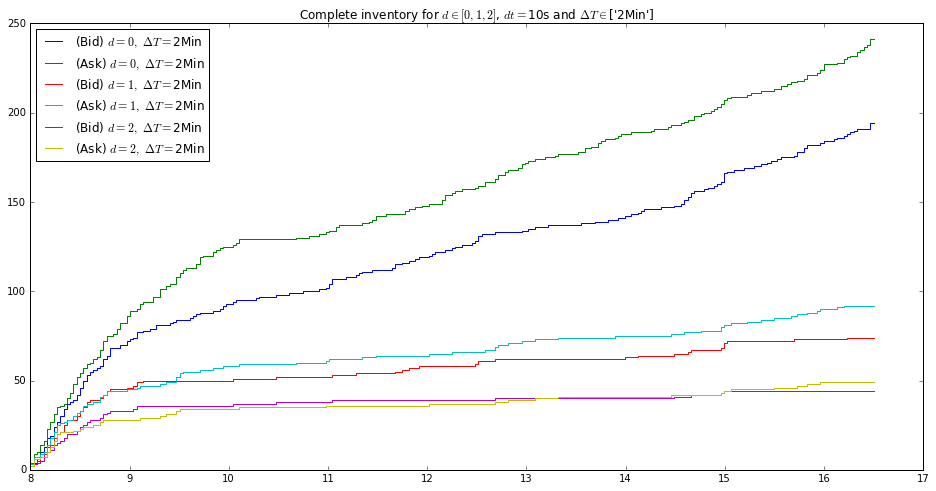

In [26]:
plotCompleteInventory()

Sans surprise, le meilleur accès à la liquidité se trouve près de la première limite. On verra plus tard que les autres limites sont intéressantes sous considération du prix obtenus pour les échanges.

In [27]:
def staticMarketMaking(db_l=[0,1,2], da_l=[0,1,2], dt='10s', DT_l=['2Min'], Hm=8, HM=16.5, J=J,
                          Width=16, Height=8, showBids=False, showAsks=False): 
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp_trades = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
        
    # Plot
    fig = plt.figure(figsize=(Width,Height))#, sharex=True)
    ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
    ax2 = plt.subplot2grid((4,4), (1,0), colspan=4, rowspan=3)
    ax1.set_title('Static MM for $d_b\in'+str(db_l)+'$, $d_a\in'
                    +str(da_l)+'$, $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
    price = temp_trades['price'].resample(DT_l[len(DT_l)-1]).mean()
    ax1.step(np.linspace(Hm,HM,len(price)), price, color='black')
    ax1.legend()
    for DT in DT_l:
        price = temp_trades['price'].resample(DT).mean()
        for db in db_l:
            for da in da_l:
                fillBid = completeFillrate(temp_trades, db, dt, DT)['Bid']
                invBid = (fillBid*price).cumsum()
                fillAsk = completeFillrate(temp_trades, da, dt, DT)['Ask']
                invAsk = (fillAsk*price).cumsum()
                if showBids:
                    ax2.step(np.linspace(Hm,HM,len(invBid)), invBid, label='$d_b='+str(db)+',\ \Delta T=$'+DT)
                if showAsks:
                    ax2.step(np.linspace(Hm,HM,len(invAsk)), -invAsk, label='$d_a='+str(da)+',\ \Delta T=$'+DT)
                ax2.step(np.linspace(Hm,HM,len(invAsk)), invBid-invAsk,
                        label='$d_b='+str(db)+',\ d_a='+str(da)+',\ \Delta T=$'+DT)
    ax2.legend(loc=2)
    fig.subplots_adjust(hspace=0)  
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.set_yticks(ax1.get_yticks()[1:]) 
    plt.setp(ax2.get_xticklabels(), visible=True)
    ax2.set_yticks(ax2.get_yticks()[1:]) 
    
    plt.show()

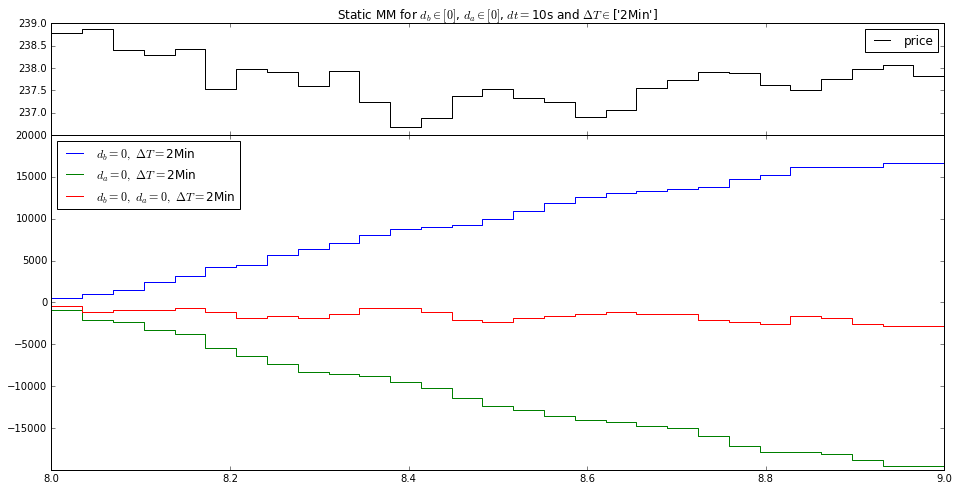

In [28]:
# Représentation des apports achats et ventes
staticMarketMaking(db_l=[0], da_l=[0], HM=9, showBids=True, showAsks=True, Height=8)

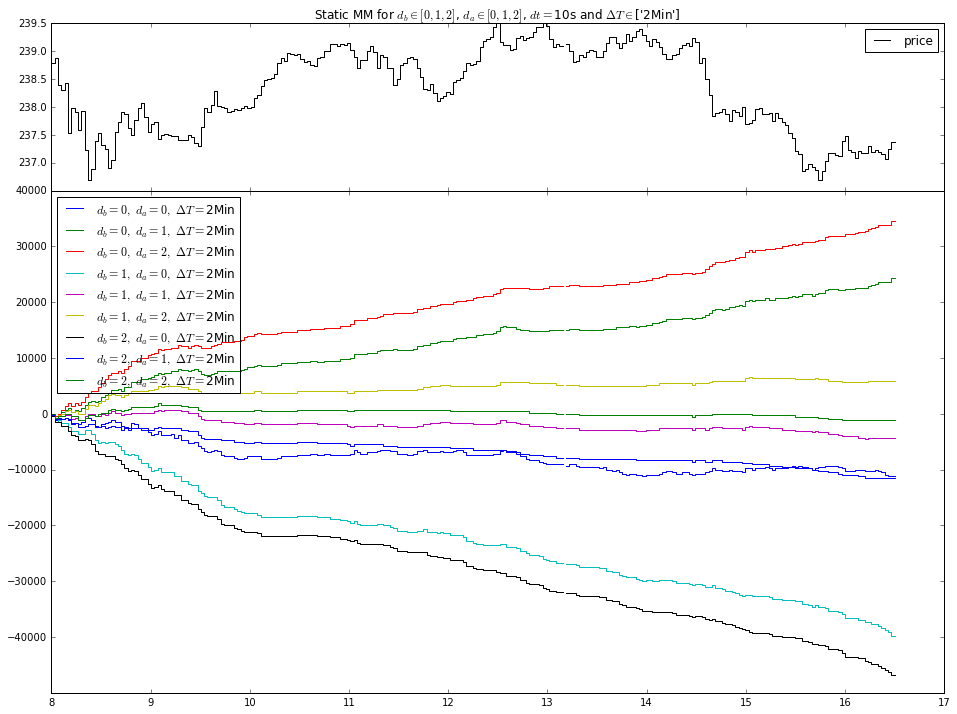

In [29]:
# Comparaison des stratégies possibles
staticMarketMaking(Height=12)

Cette simple commande nous permet de repérer très rapidement quelles sont les meilleures stratégies de la journée. Ici, on peut observer une nette surperformance des couples $(d_b, d_a)\in\{(0,0),(1,1),(2,2),(1,2),(2,1)\}$ pour rester _relativement_ stationnaires, avec une particulière stabilité pour $\{(1,1),(2,2)\}$ ce qui semble logique (symétrie et relativement éloignement de la première limite pour limiter l'agitation).

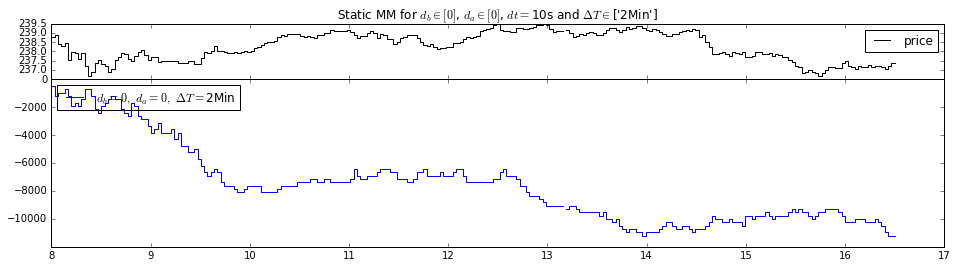

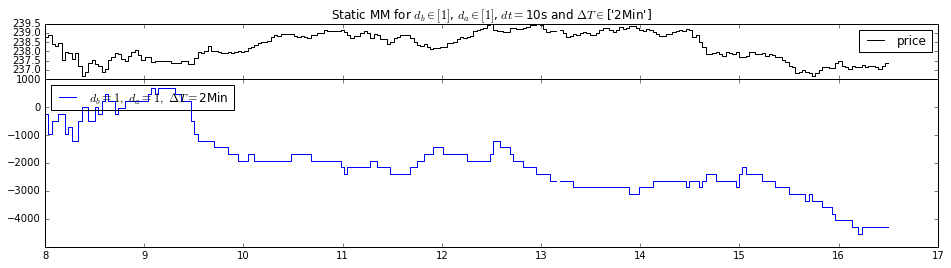

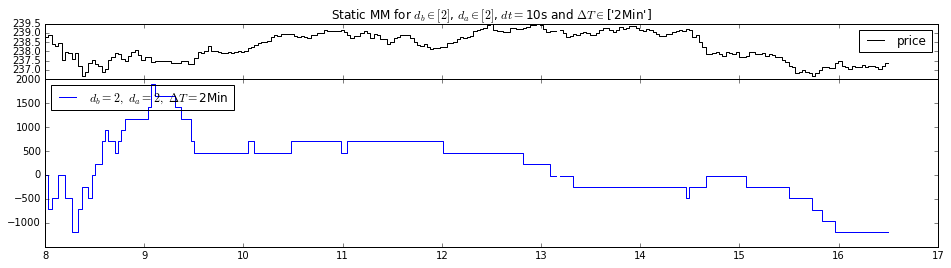

In [30]:
#Comparaison des stratégies symétriques.
staticMarketMaking(db_l=[0], da_l=[0], Height=4)
staticMarketMaking(db_l=[1], da_l=[1], Height=4)
staticMarketMaking(db_l=[2], da_l=[2], Height=4)

J=1


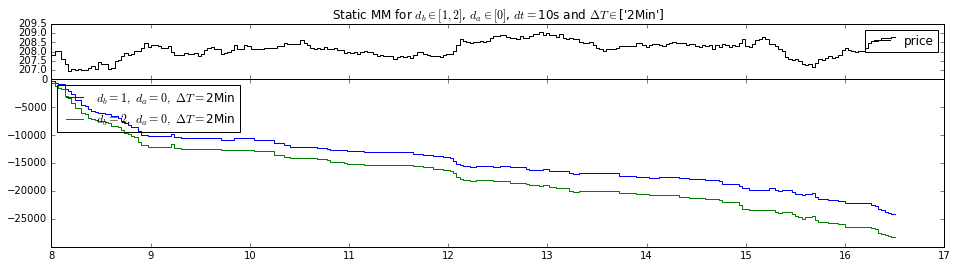

J=3


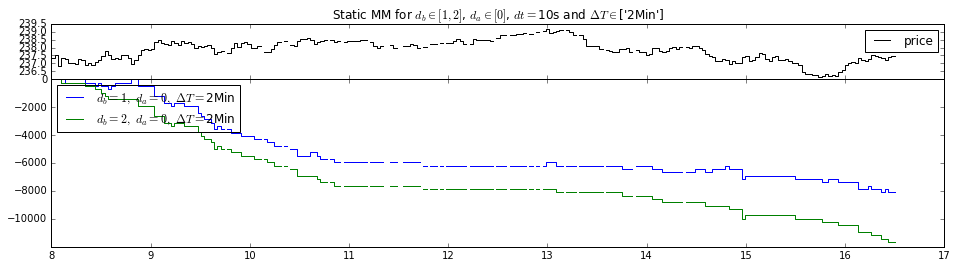

J=4


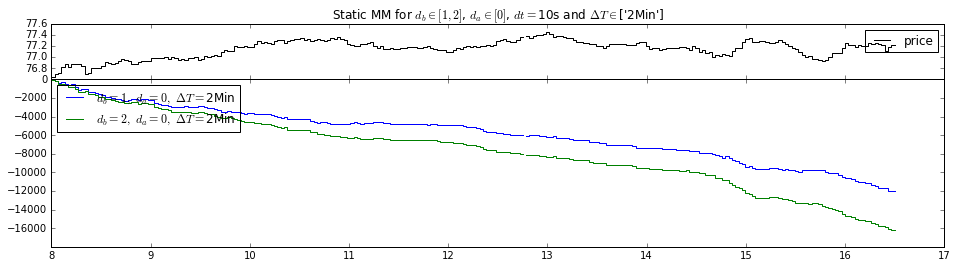

J=5


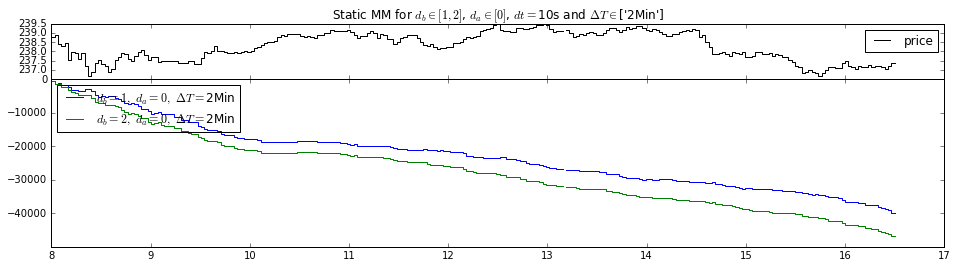

J=6


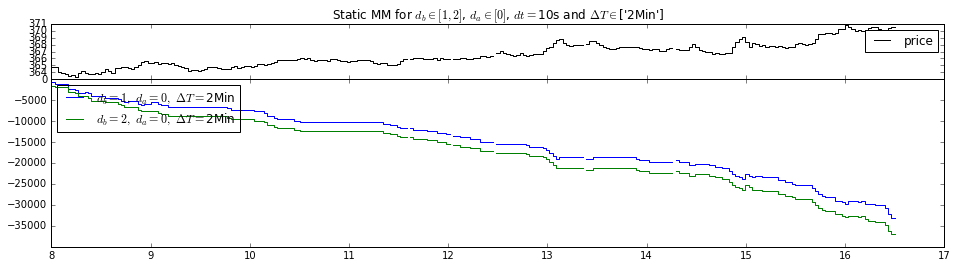

J=7


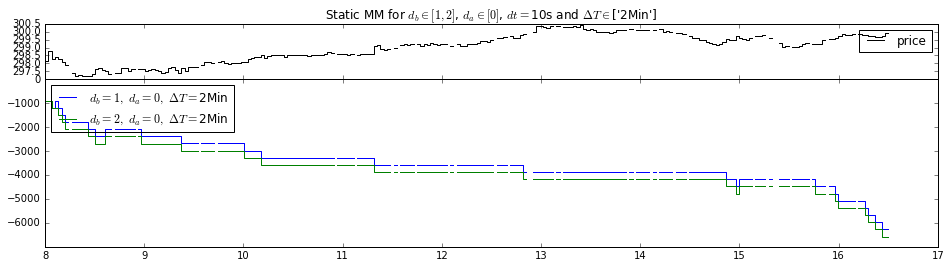

J=8


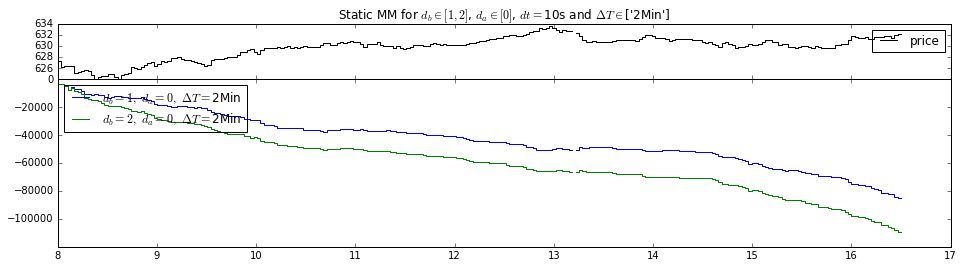

J=9


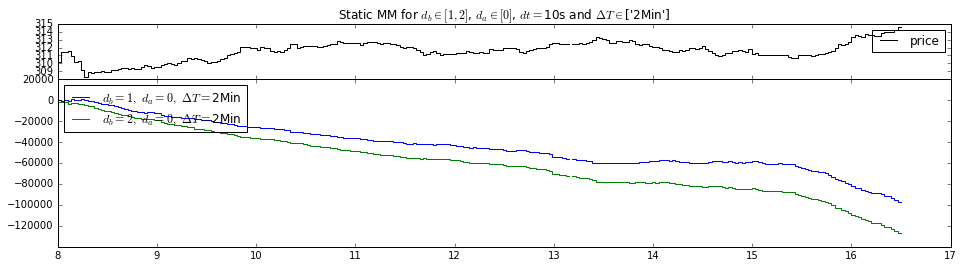

In [31]:
# Résultats sur les différentes données :
for j in [1]+range(3,10):
    print('J='+str(j))
    staticMarketMaking(db_l=[1,2], da_l=[0], J=j, Height=4)

### 3. Dynamical Market Making

L'énoncé nous demande de fixer $\Delta T$ à _"a few minutes"_, ce qui correspondont _grosso modo_ aux valeurs prises jusqu'ici.  
Commençons par regarder à quoi ressemble la volatilité.

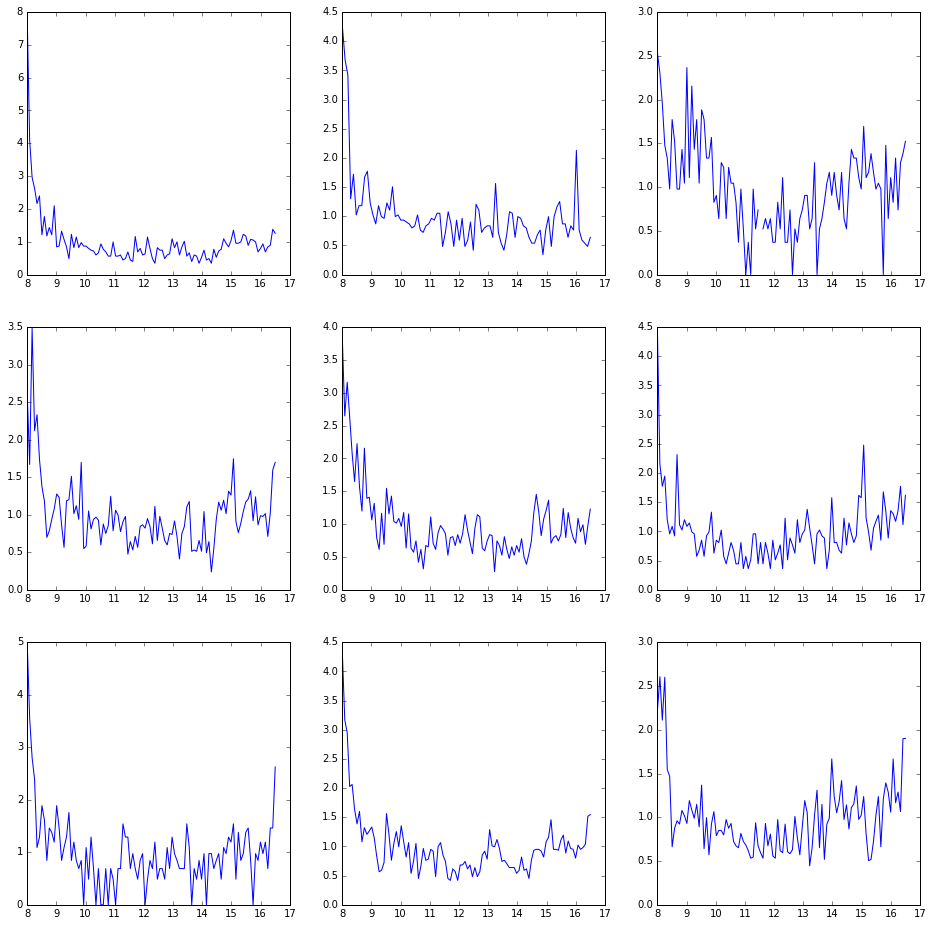

In [32]:
f, ax = plt.subplots(3,3,figsize=(16,16))
for J in range(1,10):    
    vol = (((trades[J]['price']-trades[J]['price'].shift()).apply(lambda x: x**2)).resample('5Min').sum()).apply(np.sqrt)
    vol = vol/vol.mean()
    J = J-1
    ax[floor(J/3)][J-3*floor(J/3)].plot(np.linspace(8,16.5,len(vol)), vol)
plt.show()

On remarque que la volatilité $\sigma$ est de façon générale comprise dans $[0,3]$. De plus, il semble naturel de s'éloigner de la première limite quand la volatilité est grande, et ce pour deux raisons :
 - en tant que _Market Maker_, on augmente naturellement notre marge quand le risque représenté par la volatilité augmente;
 - une grande volatilité est synonyme de relativement grands mouvements de prix, et donc il peut être rentable de s'éloigner de la première limite car on sait que l'on a quand même de grande chance d'être atteint.
 
On construit alors un _fillrate_ dynamique, qui se place en $d=\lfloor c\times\sigma\rfloor$. 

In [33]:
def dfloor(x):
    if (x>=2):
        return 2
    else:
        return floor(x)

def dfun(c,x):
    return dfloor(c*x)

In [34]:
def dynFillrate(Trades, c, dt, DT):
    Bid_dist = ['bid', 'bid1', 'bid2']
    Ask_dist = ['ask', 'ask1', 'ask2']
    
    vol = (((Trades['price']-Trades['price'].shift()).apply(lambda x: x**2)).resample(DT).sum()).apply(np.sqrt)
    vol = vol/vol.mean()
    d = vol.apply(lambda x: dfun(c,x))
    
    resBid = Trades['price'].resample(dt).min()
    for i in range(len(d)):
        resBid[i] = (resBid[i]<Trades[Bid_dist[d[i]]].resample(dt).first()[i])
    
    resAsk = Trades['price'].resample(dt).max()
    for i in range(len(d)):
        resAsk[i] = (resAsk[i]>Trades[Ask_dist[d[i]]].resample(dt).first()[i])
    
    res = {}
    res['Bid'] = resBid.resample(DT).sum()    
    res['Ask'] = resAsk.resample(DT).sum()  
    res['d'] = d
    
    return res

In [35]:
def plotDynMM(cb_l = [2**i for i in range(-1,2)], ca_l = [2**i for i in range(-1,2)], 
              dt='10s', DT_l=['2Min'], Hm=8, HM=16.5, J=J,
              Width=16, Height=8, showGains=True, showInvValue=True): 
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp_trades = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
        
    # Plot
    fig = plt.figure(figsize=(Width,Height))#, sharex=True)
    ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
    ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
    ax3 = plt.subplot2grid((4,4), (2,0), colspan=4, rowspan=2)
    ax1.set_title('Dynamic MM for $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
    price = temp_trades['price'].resample(DT_l[len(DT_l)-1]).mean()
    for DT in DT_l:
        price = temp_trades['price'].resample(DT).mean()
        N = len(price)
        ax1.step(np.linspace(Hm,HM,N), price, label='Price')
        for cb in cb_l:
            resB = dynFillrate(temp_trades, cb, dt, DT)
            fillBid = resB['Bid']
            priceBid = (fillBid*price).cumsum()
            invBid = fillBid.cumsum()
            for ca in ca_l:
                resA = dynFillrate(temp_trades, ca, dt, DT)
                fillAsk = resA['Ask']
                priceAsk = (fillAsk*price).cumsum()
                invAsk = fillAsk.cumsum()
                if showGains:
                    ax2.plot(np.linspace(Hm,HM,N), priceAsk-priceBid, ':',
                             label='Gains [$(c_B,c_A)=('+str(cb)+','+str(ca)+')$]')
                if showInvValue:
                    ax2.plot(np.linspace(Hm,HM,N), (invBid-invAsk)*price, '--',
                             label='InvValue [$(c_B,c_A)=('+str(cb)+','+str(ca)+')$]')
                ax3.step(np.linspace(Hm,HM,N), priceAsk-priceBid+(invBid-invAsk)*price,
                            label='Gains + Inv*Price [$(c_B,c_A)=('+str(cb)+','+str(ca)+')$]')
    ax1.legend()
    ax2.legend()
    ax3.legend(loc=2)
    fig.subplots_adjust(hspace=0)  
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.set_yticks(ax1.get_yticks()[1:]) 
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.set_yticks(ax2.get_yticks()[1:])
    plt.setp(ax3.get_xticklabels(), visible=True)
    ax3.set_yticks(ax3.get_yticks()) 
    
    plt.show()

J=5 :


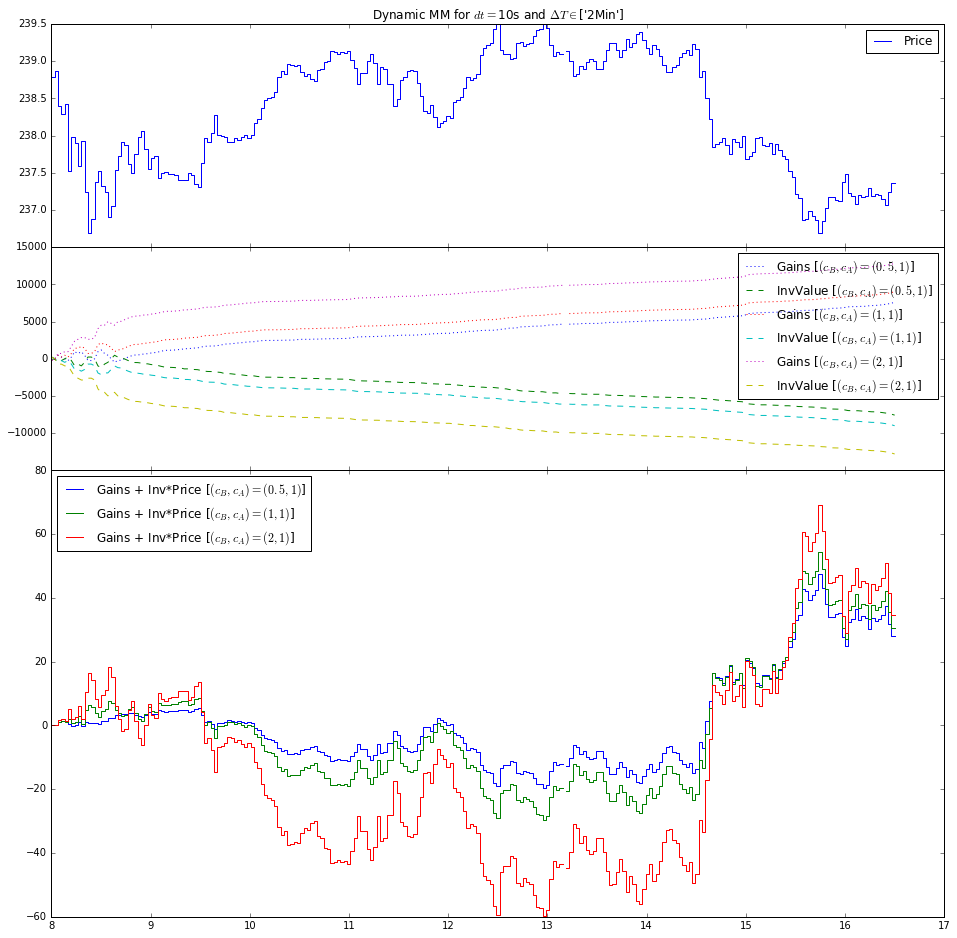

In [ ]:
print('J=5 :')
plotDynMM(ca_l=[1], J=5, Height=16)

J=1


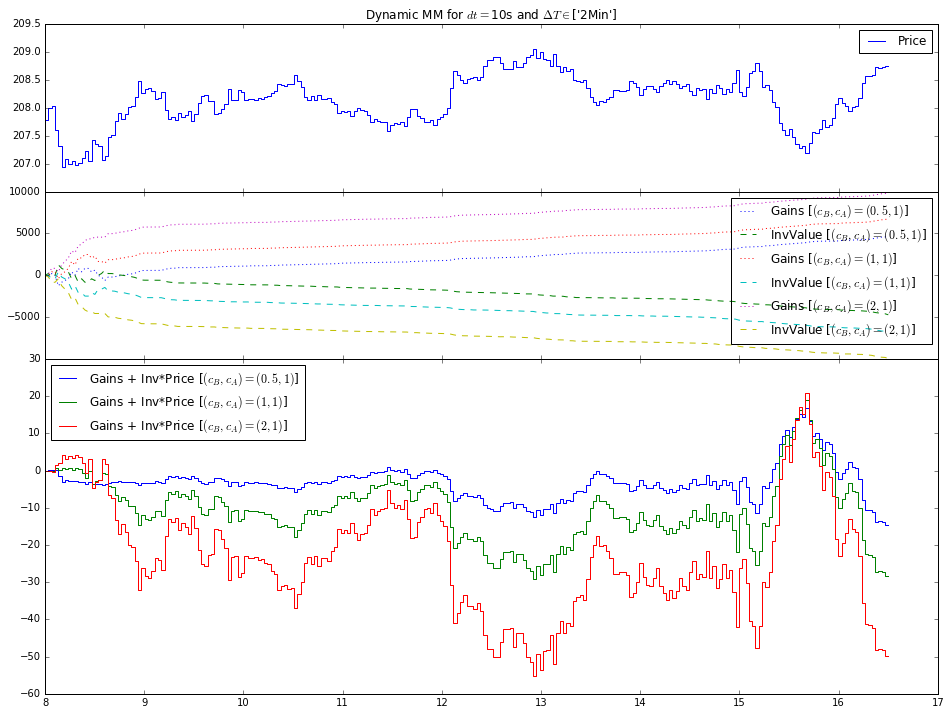

J=2


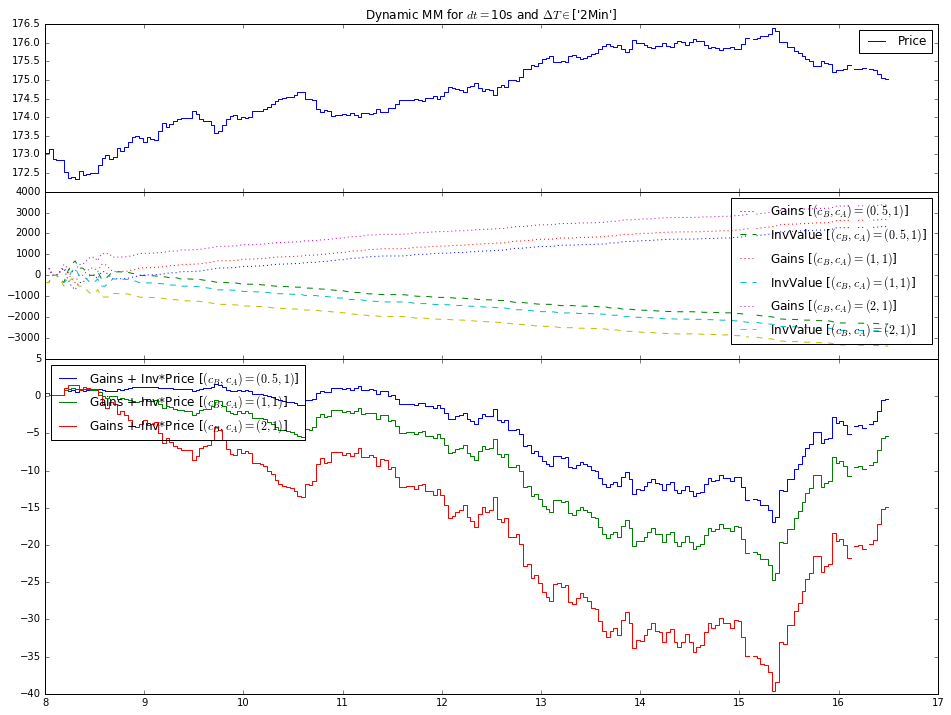

J=3


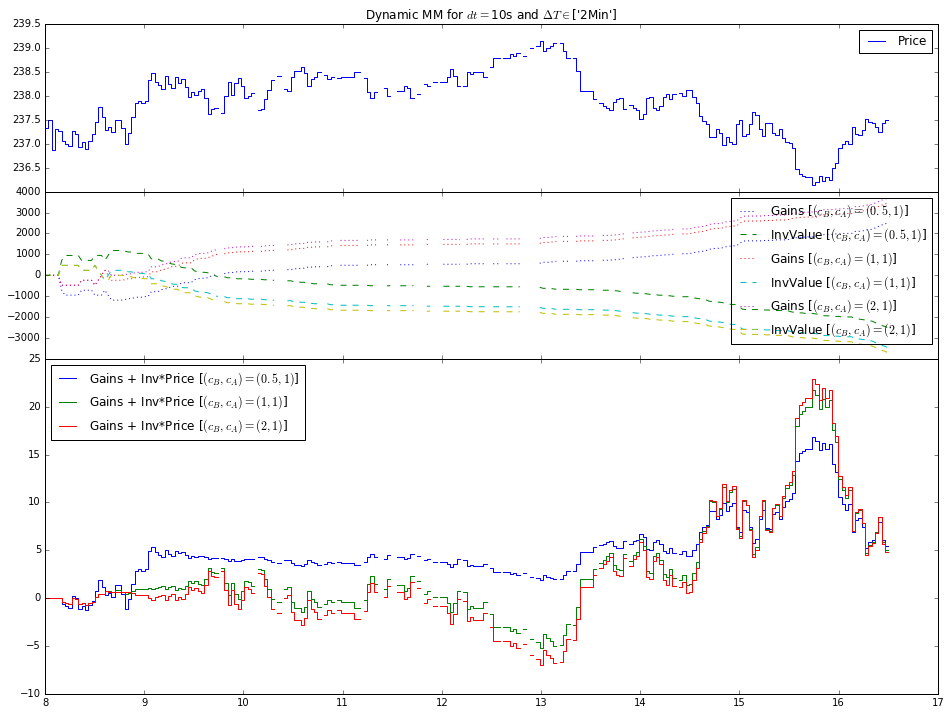

In [ ]:
# Résultats sur les différentes données :
for J in range(1,10):
    print('J='+str(J))
    plotDynMM(ca_l=[1], J=J, Height=12)

De façon générale, on remarque que les bonnes stratégies sont également celles qui sont capables de bien gérer leur inventaire.

## IV. Profit & Loss

## Conclusion